In [1]:
# 
# This script uses parts of scripts 'turn_aend_action_lattice_edit.py' (Chris) 
# and 'variabledNLsimulation_v0.py' (Yury)
#
#    Started at June 13, 2019
#
import synergia
import sys
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import rssynergia 
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import plotbeam
from rssynergia.base_diagnostics import pltbunch

def plotcoordDistr(bunchParticles):
#    
# Plot X-X', Y-Y', and X-Y distributions for 'bunchParticles'
#
    shapePartcls = bunchParticles.shape
    numbPartcls = shapePartcls[0]
    shapePartcls[0]
    particles = bunchParticles.real
    newCoordinates = np.zeros((6,numbPartcls))
    for k in range(numbPartcls):
        for j in range(6):
            newCoordinates[j,k] = 1.e3*particles[k,j]       # Units: mm and mrad 
    xmax = 1.15*np.max(newCoordinates[0,:])
    xpmax = 1.15*np.max(newCoordinates[1,:])
    ymax = 1.15*np.max(newCoordinates[2,:])
    ypmax = 1.15*np.max(newCoordinates[3,:])
    meanX = np.mean(newCoordinates[0,:])
    meanPX = np.mean(newCoordinates[1,:])
    stdX = np.std(newCoordinates[0,:])
    stdPX = np.std(newCoordinates[1,:])
    meanY = np.mean(newCoordinates[2,:])
    meanPY = np.mean(newCoordinates[3,:])
    stdY = np.std(newCoordinates[2,:])
    stdPY = np.std(newCoordinates[3,:])

    #another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(newCoordinates[0,:],newCoordinates[2,:],'.',color='k')
    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
    ax0.set_title(x0Title,fontsize='16')
    ax0.set_xlim([-xmax,xmax])
    ax0.set_ylim([-ymax,ymax])
    ax0.set_xlabel('X, mm')
    ax0.set_ylabel('Y, mm')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(newCoordinates[0,:],newCoordinates[1,:],'.',color='b')
    x1Title = "X,mm: <> = {:.3f} +- {:.3f}\nX\',mrad: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanPX,stdPX)
    ax1.set_title(x1Title,fontsize='16')
    ax1.set_xlim([-xmax,xmax])
    ax1.set_ylim([-xpmax,xpmax])
    ax1.set_xlabel('X, mm')
    ax1.set_ylabel('X\', mrad')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(newCoordinates[2,:],newCoordinates[3,:],'.',color='r')
    x2Title = "Y,mm: <> = {:.3f} +- {:.3f}\nY\',mrad: <> = {:.3f} +- {:.3f}".format(meanY,stdY,meanPY,stdPY)
    ax2.set_title(x2Title,fontsize='16')
    ax2.set_xlim([-ymax,ymax])
    ax2.set_ylim([-ypmax,ypmax])
    ax2.set_xlabel('Y, mm')
    ax2.set_ylabel('Y\', mrad')
    ax2.grid(True)
    
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

# Pickle helper is not necessary but is retained for this example
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state
        
# Derived class to ramp quadrupoles

# Will be passed into propagator and called at each appropriate 'interval' (step, turn, action, etc...)

class Ramp_actions(synergia.simulation.Propagate_actions, Pickle_helper):
# The arguments to __init__ are what the Ramp_actions instance is initialized with
    def __init__(self, multiplier1,multiplier2):
        selfObject = synergia.simulation.Propagate_actions.__init__(self)
# To recognize attributes of 'selfObject':
#        printAttributes(selfObject,'selfObject','synergia.simulation.Propagate_actions.__init__(self)')

# Pickling the arguments to the initializer allows the module to resume
# after checkpointing. They should be in the same order as the arguments to __init__.
        Pickle_helper.__init__(self, multiplier1,multiplier2)
        self.multiplier1 = multiplier1
        self.multiplier2 = multiplier2
    def turn_end_action(self, stepper, bunch, turn_num):
# For checking:        
        print "Modifying lattice:"
        for element in stepper.get_lattice_simulator().get_lattice().get_elements():
            if element.get_type() == "nllens":
                old_knll = element.get_double_attribute("knll")
                element.set_double_attribute("knll", self.multiplier1*old_knll)
                old_cnll = element.get_double_attribute("cnll")
                element.set_double_attribute("cnll", self.multiplier2*old_cnll)
# For checking:        
                print "Update", element.get_name(),": knll = ",old_knll," --> ",self.multiplier1*old_knll, \
                "; cnll = ",old_cnll," --> ",self.multiplier2*old_cnll
        stepper.get_lattice_simulator().update()
    
# Routine Simulation Setup

# Lattice:
print "\nIOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'\n"
lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
"../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")
# To recognize attributes of 'lattice':
# printAttributes(lattice,'lattice','synergia.lattice.MadX_reader().get_lattice')

'''
# For checking only:
k = 0
for elem in lattice.get_elements():
    if k == 0:
        printAttributes(elem,'elem','lattice.get_elements')
    k += 1
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
    else:
        elem.set_string_attribute("extractor_type", "chef_map")
    print "elem ({}): name = {}, type = {}, stringAttrbt ={}". \
          format(k,elem.get_name(),elem.get_type(),elem.get_string_attribute("extractor_type"))
'''    

# Original version:
# attice_simulator = synergia.simulation.Lattice_simulator(lattice, 2)
# Bunch:
# bunch = synergia.optics.generate_matched_bunch_transverse(lattice_simulator, 1e-6, \
#                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)

# YuE version:
stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# Bunch:
bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)
#-------------------------------------------------
# For checking only:
#
# 1) Attributes:
# printAttributes(bunch,'bunch','synergia.optics.generate_matched_bunch_transverse')
# 2) Distributions X-Y, X-X', Y-Y' using method 'pltbunch.plot_bunch':
loclTitle = "\nThese distributions were constructed using \
'synergia.optics.generated_matched_bunch_transverse' method:\n"
print loclTitle
pltbunch.plot_bunch(bunch_origin)     
# 3) Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
# printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
plotcoordDistr(bunchParticles)



IOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'


These distributions were constructed using 'synergia.optics.generated_matched_bunch_transverse' method:



<Figure size 1500x500 with 3 Axes>

<Figure size 1500x500 with 3 Axes>


IOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'


These distributions were constructed using 'synergia.optics.generated_matched_bunch_transverse' method:



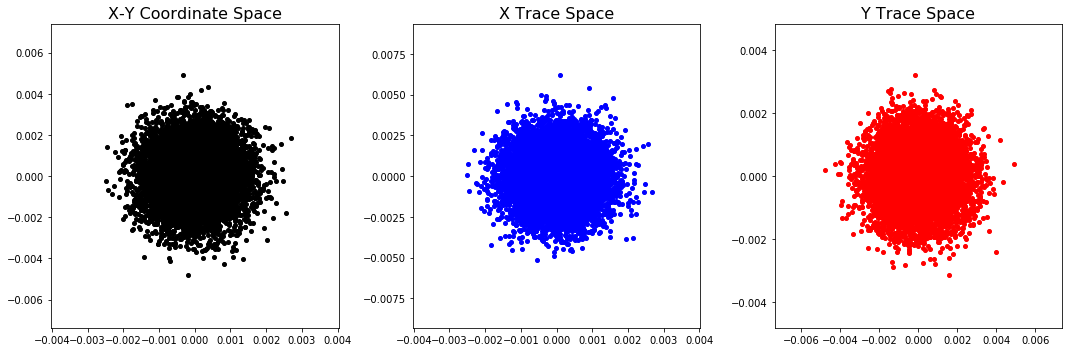

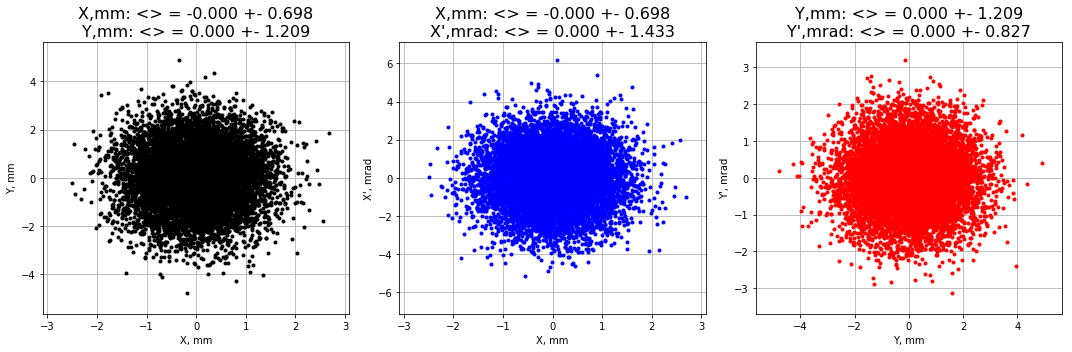

In [2]:
# 
# This script uses parts of scripts 'turn_aend_action_lattice_edit.py' (Chris) 
# and 'variabledNLsimulation_v0.py' (Yury)
#
#    Started at June 13, 2019
#
import synergia
import sys
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import rssynergia 
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import plotbeam
from rssynergia.base_diagnostics import pltbunch

def plotcoordDistr(bunchParticles):
#    
# Plot X-X', Y-Y', and X-Y distributions for 'bunchParticles'
#
    shapePartcls = bunchParticles.shape
    numbPartcls = shapePartcls[0]
    shapePartcls[0]
    particles = bunchParticles.real
    newCoordinates = np.zeros((6,numbPartcls))
    for k in range(numbPartcls):
        for j in range(6):
            newCoordinates[j,k] = 1.e3*particles[k,j]       # Units: mm and mrad 
    xmax = 1.15*np.max(newCoordinates[0,:])
    xpmax = 1.15*np.max(newCoordinates[1,:])
    ymax = 1.15*np.max(newCoordinates[2,:])
    ypmax = 1.15*np.max(newCoordinates[3,:])
    meanX = np.mean(newCoordinates[0,:])
    meanPX = np.mean(newCoordinates[1,:])
    stdX = np.std(newCoordinates[0,:])
    stdPX = np.std(newCoordinates[1,:])
    meanY = np.mean(newCoordinates[2,:])
    meanPY = np.mean(newCoordinates[3,:])
    stdY = np.std(newCoordinates[2,:])
    stdPY = np.std(newCoordinates[3,:])

    #another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(newCoordinates[0,:],newCoordinates[2,:],'.',color='k')
    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
    ax0.set_title(x0Title,fontsize='16')
    ax0.set_xlim([-xmax,xmax])
    ax0.set_ylim([-ymax,ymax])
    ax0.set_xlabel('X, mm')
    ax0.set_ylabel('Y, mm')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(newCoordinates[0,:],newCoordinates[1,:],'.',color='b')
    x1Title = "X,mm: <> = {:.3f} +- {:.3f}\nX\',mrad: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanPX,stdPX)
    ax1.set_title(x1Title,fontsize='16')
    ax1.set_xlim([-xmax,xmax])
    ax1.set_ylim([-xpmax,xpmax])
    ax1.set_xlabel('X, mm')
    ax1.set_ylabel('X\', mrad')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(newCoordinates[2,:],newCoordinates[3,:],'.',color='r')
    x2Title = "Y,mm: <> = {:.3f} +- {:.3f}\nY\',mrad: <> = {:.3f} +- {:.3f}".format(meanY,stdY,meanPY,stdPY)
    ax2.set_title(x2Title,fontsize='16')
    ax2.set_xlim([-ymax,ymax])
    ax2.set_ylim([-ypmax,ypmax])
    ax2.set_xlabel('Y, mm')
    ax2.set_ylabel('Y\', mrad')
    ax2.grid(True)
    
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

# Pickle helper is not necessary but is retained for this example
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state
        
# Derived class to ramp quadrupoles

# Will be passed into propagator and called at each appropriate 'interval' (step, turn, action, etc...)

class Ramp_actions(synergia.simulation.Propagate_actions, Pickle_helper):
# The arguments to __init__ are what the Ramp_actions instance is initialized with
    def __init__(self, multiplier1,multiplier2):
        selfObject = synergia.simulation.Propagate_actions.__init__(self)
# To recognize attributes of 'selfObject':
#        printAttributes(selfObject,'selfObject','synergia.simulation.Propagate_actions.__init__(self)')

# Pickling the arguments to the initializer allows the module to resume
# after checkpointing. They should be in the same order as the arguments to __init__.
        Pickle_helper.__init__(self, multiplier1,multiplier2)
        self.multiplier1 = multiplier1
        self.multiplier2 = multiplier2
    def turn_end_action(self, stepper, bunch, turn_num):
# For checking:        
        print "Modifying lattice:"
        for element in stepper.get_lattice_simulator().get_lattice().get_elements():
            if element.get_type() == "nllens":
                old_knll = element.get_double_attribute("knll")
                element.set_double_attribute("knll", self.multiplier1*old_knll)
                old_cnll = element.get_double_attribute("cnll")
                element.set_double_attribute("cnll", self.multiplier2*old_cnll)
# For checking:        
                print "Update", element.get_name(),": knll = ",old_knll," --> ",self.multiplier1*old_knll, \
                "; cnll = ",old_cnll," --> ",self.multiplier2*old_cnll
        stepper.get_lattice_simulator().update()
    
# Routine Simulation Setup

# Lattice:
print "\nIOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'\n"
lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
"../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")
# To recognize attributes of 'lattice':
# printAttributes(lattice,'lattice','synergia.lattice.MadX_reader().get_lattice')

'''
# For checking only:
k = 0
for elem in lattice.get_elements():
    if k == 0:
        printAttributes(elem,'elem','lattice.get_elements')
    k += 1
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
    else:
        elem.set_string_attribute("extractor_type", "chef_map")
    print "elem ({}): name = {}, type = {}, stringAttrbt ={}". \
          format(k,elem.get_name(),elem.get_type(),elem.get_string_attribute("extractor_type"))
'''    

# Original version:
# attice_simulator = synergia.simulation.Lattice_simulator(lattice, 2)
# Bunch:
# bunch = synergia.optics.generate_matched_bunch_transverse(lattice_simulator, 1e-6, \
#                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)

# YuE version:
stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# Bunch:
bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)
#-------------------------------------------------
# For checking only:
#
# 1) Attributes:
# printAttributes(bunch,'bunch','synergia.optics.generate_matched_bunch_transverse')
# 2) Distributions X-Y, X-X', Y-Y' using method 'pltbunch.plot_bunch':
loclTitle = "\nThese distributions were constructed using \
'synergia.optics.generated_matched_bunch_transverse' method:\n"
print loclTitle
pltbunch.plot_bunch(bunch_origin)     
# 3) Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
# printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
plotcoordDistr(bunchParticles)



IOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'


These distributions were constructed using 'synergia.optics.generated_matched_bunch_transverse' method:



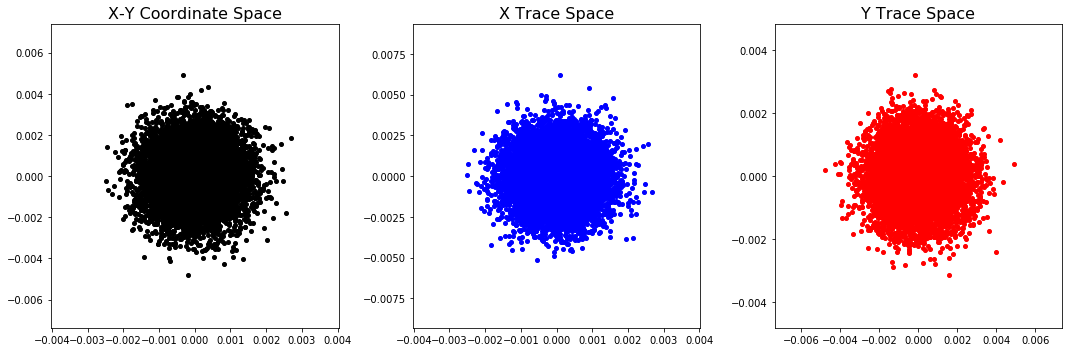

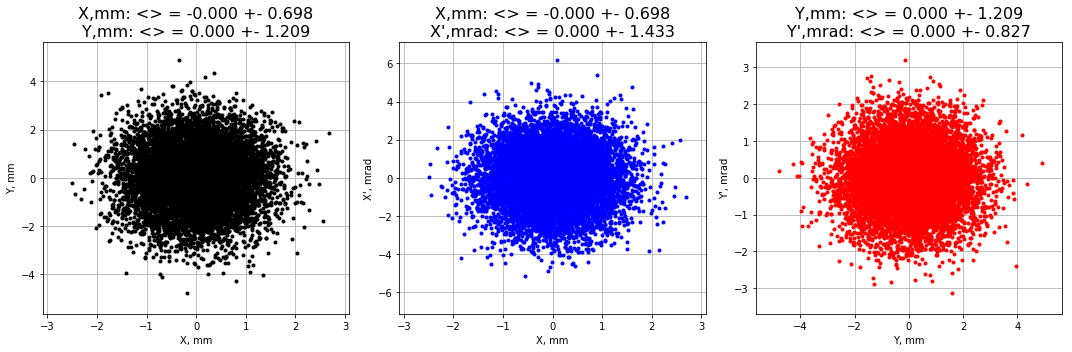


-------------------

           Nonlinear parameters are not changed

-------------------

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.479576037e-06 ; cnll =  0.008105461952  -->  0.008105461952
Update n.12 : knll =  5.280450528e-06  -->  5.280450528e-06 ; cnll =  0.008256875978  -->  0.008256875978
Update n.13 : knll =  4.922674639e-06  -->  4.922674639e-06 ; cnll =  0.008551665091  -->  0.008551665091
Update n.14 : knll =  4.468528256e-06  -->  4.468528256e-06 ; cnll =  0.008975713799  -->  0.008975713799
Update n.15 : knll =  3.979070618e-06  -->  3.979070618e-06 ; cnll =  0.009511749998  -->  0.009511749998
Update n.16 : knll =  3.499874699e-06  -->  3.499874699e-06 ; cnll =  0.0101420326  -->  0.0101420326
Update n.17 : knll =  3.057954609e-06  -->  3.057954609e-06 ; cnll =  0.01085014977  -->  0.01085014977
Update n.18 : knll =  2.665320931e-06  -->  2.665320931e-06 ; cnll =  0.0116218829  -->  0.0116218829
Update n.19 : knll =  2.324259182e-06  -->  2.32425

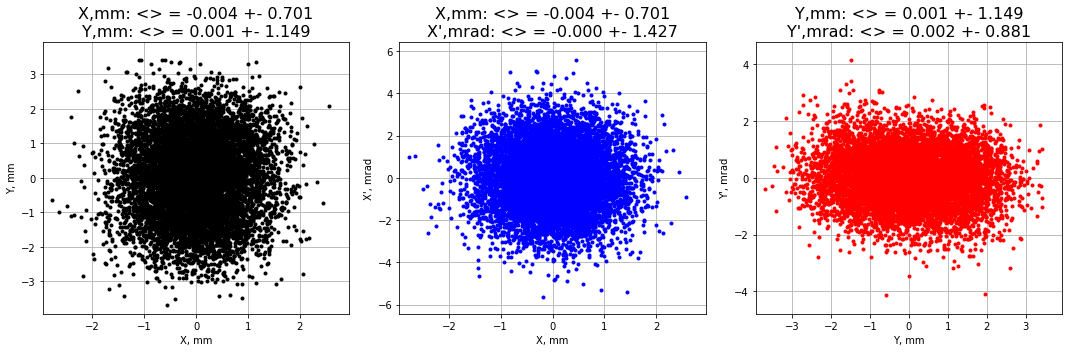

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.479576037e-06 ; cnll =  0.008105461952  -->  0.008105461952
Update n.12 : knll =  5.280450528e-06  -->  5.280450528e-06 ; cnll =  0.008256875978  -->  0.008256875978
Update n.13 : knll =  4.922674639e-06  -->  4.922674639e-06 ; cnll =  0.008551665091  -->  0.008551665091
Update n.14 : knll =  4.468528256e-06  -->  4.468528256e-06 ; cnll =  0.008975713799  -->  0.008975713799
Update n.15 : knll =  3.979070618e-06  -->  3.979070618e-06 ; cnll =  0.009511749998  -->  0.009511749998
Update n.16 : knll =  3.499874699e-06  -->  3.499874699e-06 ; cnll =  0.0101420326  -->  0.0101420326
Update n.17 : knll =  3.057954609e-06  -->  3.057954609e-06 ; cnll =  0.01085014977  -->  0.01085014977
Update n.18 : knll =  2.665320931e-06  -->  2.665320931e-06 ; cnll =  0.0116218829  -->  0.0116218829
Update n.19 : knll =  2.324259182e-06  -->  2.324259182e-06 ; cnll =  0.01244540324  -->  0.01244540324
Update n.20 : knll =  2.03176955e-06  -

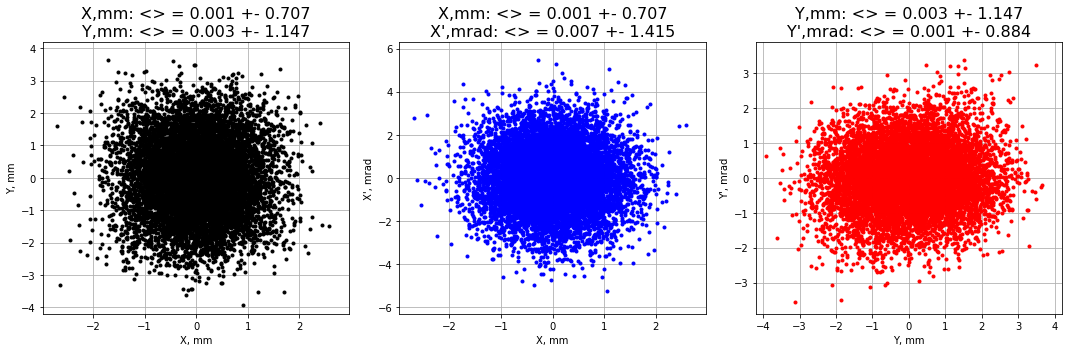

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.479576037e-06 ; cnll =  0.008105461952  -->  0.008105461952
Update n.12 : knll =  5.280450528e-06  -->  5.280450528e-06 ; cnll =  0.008256875978  -->  0.008256875978
Update n.13 : knll =  4.922674639e-06  -->  4.922674639e-06 ; cnll =  0.008551665091  -->  0.008551665091
Update n.14 : knll =  4.468528256e-06  -->  4.468528256e-06 ; cnll =  0.008975713799  -->  0.008975713799
Update n.15 : knll =  3.979070618e-06  -->  3.979070618e-06 ; cnll =  0.009511749998  -->  0.009511749998
Update n.16 : knll =  3.499874699e-06  -->  3.499874699e-06 ; cnll =  0.0101420326  -->  0.0101420326
Update n.17 : knll =  3.057954609e-06  -->  3.057954609e-06 ; cnll =  0.01085014977  -->  0.01085014977
Update n.18 : knll =  2.665320931e-06  -->  2.665320931e-06 ; cnll =  0.0116218829  -->  0.0116218829
Update n.19 : knll =  2.324259182e-06  -->  2.324259182e-06 ; cnll =  0.01244540324  -->  0.01244540324
Update n.20 : knll =  2.03176955e-06  -

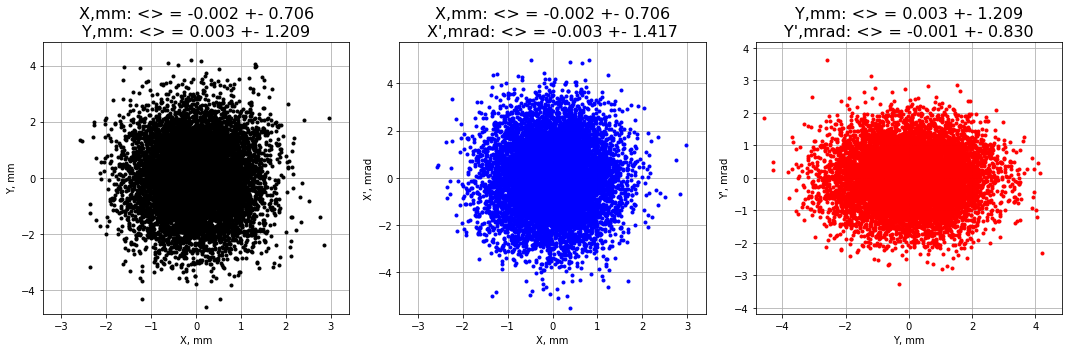

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.479576037e-06 ; cnll =  0.008105461952  -->  0.008105461952
Update n.12 : knll =  5.280450528e-06  -->  5.280450528e-06 ; cnll =  0.008256875978  -->  0.008256875978
Update n.13 : knll =  4.922674639e-06  -->  4.922674639e-06 ; cnll =  0.008551665091  -->  0.008551665091
Update n.14 : knll =  4.468528256e-06  -->  4.468528256e-06 ; cnll =  0.008975713799  -->  0.008975713799
Update n.15 : knll =  3.979070618e-06  -->  3.979070618e-06 ; cnll =  0.009511749998  -->  0.009511749998
Update n.16 : knll =  3.499874699e-06  -->  3.499874699e-06 ; cnll =  0.0101420326  -->  0.0101420326
Update n.17 : knll =  3.057954609e-06  -->  3.057954609e-06 ; cnll =  0.01085014977  -->  0.01085014977
Update n.18 : knll =  2.665320931e-06  -->  2.665320931e-06 ; cnll =  0.0116218829  -->  0.0116218829
Update n.19 : knll =  2.324259182e-06  -->  2.324259182e-06 ; cnll =  0.01244540324  -->  0.01244540324
Update n.20 : knll =  2.03176955e-06  -

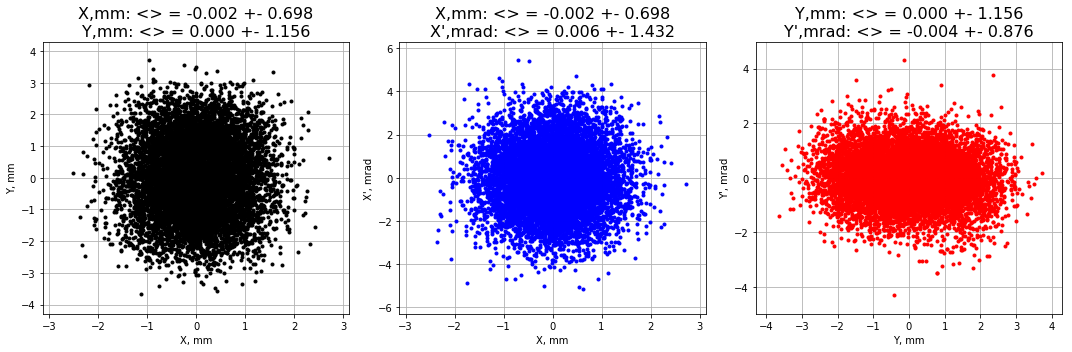

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.479576037e-06 ; cnll =  0.008105461952  -->  0.008105461952
Update n.12 : knll =  5.280450528e-06  -->  5.280450528e-06 ; cnll =  0.008256875978  -->  0.008256875978
Update n.13 : knll =  4.922674639e-06  -->  4.922674639e-06 ; cnll =  0.008551665091  -->  0.008551665091
Update n.14 : knll =  4.468528256e-06  -->  4.468528256e-06 ; cnll =  0.008975713799  -->  0.008975713799
Update n.15 : knll =  3.979070618e-06  -->  3.979070618e-06 ; cnll =  0.009511749998  -->  0.009511749998
Update n.16 : knll =  3.499874699e-06  -->  3.499874699e-06 ; cnll =  0.0101420326  -->  0.0101420326
Update n.17 : knll =  3.057954609e-06  -->  3.057954609e-06 ; cnll =  0.01085014977  -->  0.01085014977
Update n.18 : knll =  2.665320931e-06  -->  2.665320931e-06 ; cnll =  0.0116218829  -->  0.0116218829
Update n.19 : knll =  2.324259182e-06  -->  2.324259182e-06 ; cnll =  0.01244540324  -->  0.01244540324
Update n.20 : knll =  2.03176955e-06  -

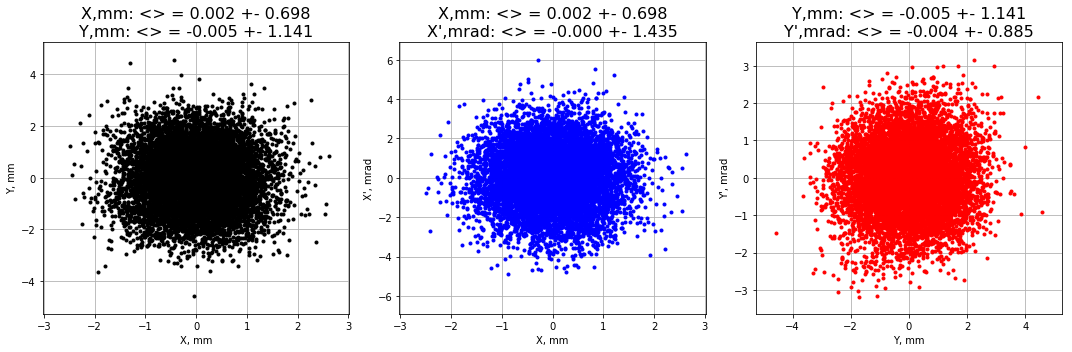


-------------------

           Nonlinear parameters will be CHANGED with values = 5% after each turn

-------------------

Modifying lattice:
Update n.11 : knll =  5.479576037e-06  -->  5.75355483885e-06 ; cnll =  0.008105461952  -->  0.0077001888544
Update n.12 : knll =  5.280450528e-06  -->  5.5444730544e-06 ; cnll =  0.008256875978  -->  0.0078440321791
Update n.13 : knll =  4.922674639e-06  -->  5.16880837095e-06 ; cnll =  0.008551665091  -->  0.00812408183645
Update n.14 : knll =  4.468528256e-06  -->  4.6919546688e-06 ; cnll =  0.008975713799  -->  0.00852692810905
Update n.15 : knll =  3.979070618e-06  -->  4.1780241489e-06 ; cnll =  0.009511749998  -->  0.0090361624981
Update n.16 : knll =  3.499874699e-06  -->  3.67486843395e-06 ; cnll =  0.0101420326  -->  0.00963493097
Update n.17 : knll =  3.057954609e-06  -->  3.21085233945e-06 ; cnll =  0.01085014977  -->  0.0103076422815
Update n.18 : knll =  2.665320931e-06  -->  2.79858697755e-06 ; cnll =  0.0116218829  -->  0.011040

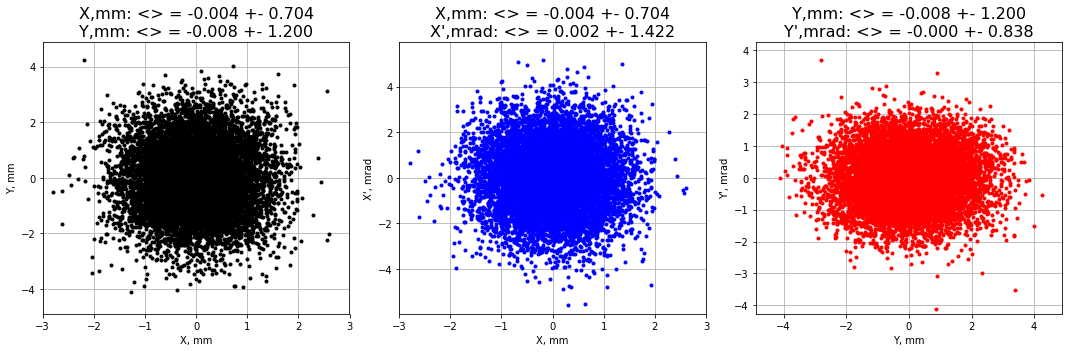

Modifying lattice:
Update n.11 : knll =  5.75355483885e-06  -->  6.04123258079e-06 ; cnll =  0.0077001888544  -->  0.00731517941168
Update n.12 : knll =  5.5444730544e-06  -->  5.82169670712e-06 ; cnll =  0.0078440321791  -->  0.00745183057014
Update n.13 : knll =  5.16880837095e-06  -->  5.4272487895e-06 ; cnll =  0.00812408183645  -->  0.00771787774463
Update n.14 : knll =  4.6919546688e-06  -->  4.92655240224e-06 ; cnll =  0.00852692810905  -->  0.0081005817036
Update n.15 : knll =  4.1780241489e-06  -->  4.38692535635e-06 ; cnll =  0.0090361624981  -->  0.00858435437319
Update n.16 : knll =  3.67486843395e-06  -->  3.85861185565e-06 ; cnll =  0.00963493097  -->  0.0091531844215
Update n.17 : knll =  3.21085233945e-06  -->  3.37139495642e-06 ; cnll =  0.0103076422815  -->  0.00979226016742
Update n.18 : knll =  2.79858697755e-06  -->  2.93851632643e-06 ; cnll =  0.011040788755  -->  0.0104887493172
Update n.19 : knll =  2.4404721411e-06  -->  2.56249574816e-06 ; cnll =  0.0118231330

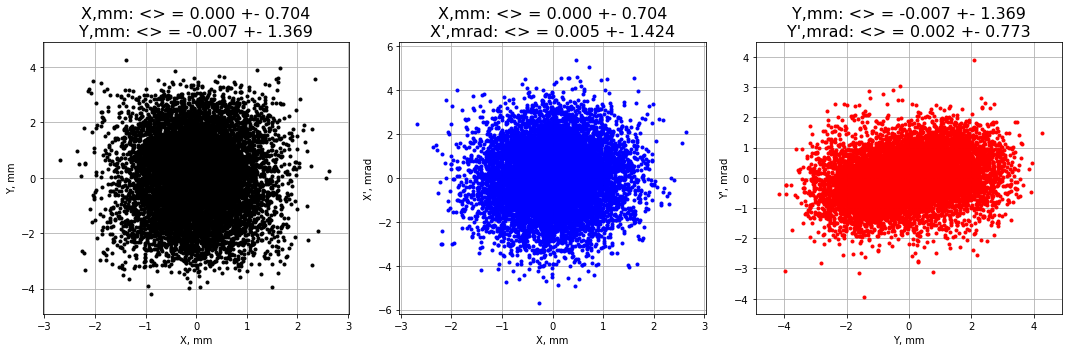

Modifying lattice:
Update n.11 : knll =  6.04123258079e-06  -->  6.34329420983e-06 ; cnll =  0.00731517941168  -->  0.0069494204411
Update n.12 : knll =  5.82169670712e-06  -->  6.11278154248e-06 ; cnll =  0.00745183057014  -->  0.00707923904164
Update n.13 : knll =  5.4272487895e-06  -->  5.69861122897e-06 ; cnll =  0.00771787774463  -->  0.0073319838574
Update n.14 : knll =  4.92655240224e-06  -->  5.17288002235e-06 ; cnll =  0.0081005817036  -->  0.00769555261842
Update n.15 : knll =  4.38692535635e-06  -->  4.60627162416e-06 ; cnll =  0.00858435437319  -->  0.00815513665454
Update n.16 : knll =  3.85861185565e-06  -->  4.05154244843e-06 ; cnll =  0.0091531844215  -->  0.00869552520042
Update n.17 : knll =  3.37139495642e-06  -->  3.53996470424e-06 ; cnll =  0.00979226016742  -->  0.00930264715905
Update n.18 : knll =  2.93851632643e-06  -->  3.08544214275e-06 ; cnll =  0.0104887493172  -->  0.00996431185139
Update n.19 : knll =  2.56249574816e-06  -->  2.69062053556e-06 ; cnll =  0

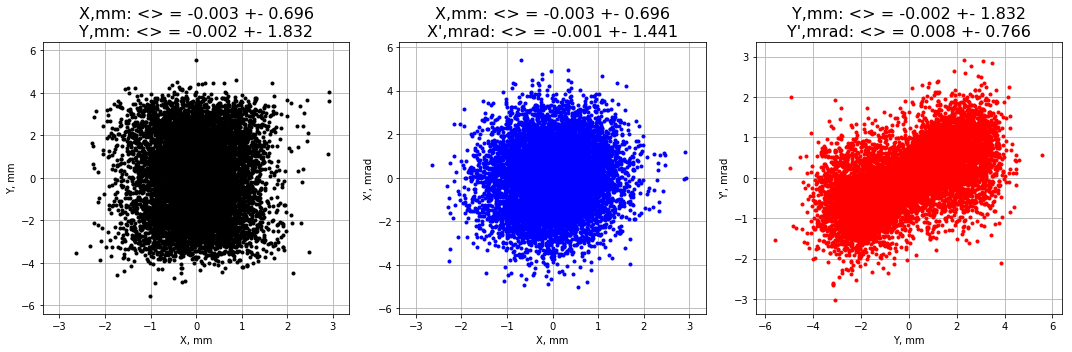

Modifying lattice:
Update n.11 : knll =  6.34329420983e-06  -->  6.66045892032e-06 ; cnll =  0.0069494204411  -->  0.00660194941904
Update n.12 : knll =  6.11278154248e-06  -->  6.4184206196e-06 ; cnll =  0.00707923904164  -->  0.00672527708956
Update n.13 : knll =  5.69861122897e-06  -->  5.98354179042e-06 ; cnll =  0.0073319838574  -->  0.00696538466453
Update n.14 : knll =  5.17288002235e-06  -->  5.43152402347e-06 ; cnll =  0.00769555261842  -->  0.0073107749875
Update n.15 : knll =  4.60627162416e-06  -->  4.83658520537e-06 ; cnll =  0.00815513665454  -->  0.00774737982181
Update n.16 : knll =  4.05154244843e-06  -->  4.25411957085e-06 ; cnll =  0.00869552520042  -->  0.0082607489404
Update n.17 : knll =  3.53996470424e-06  -->  3.71696293946e-06 ; cnll =  0.00930264715905  -->  0.0088375148011
Update n.18 : knll =  3.08544214275e-06  -->  3.23971424989e-06 ; cnll =  0.00996431185139  -->  0.00946609625882
Update n.19 : knll =  2.69062053556e-06  -->  2.82515156234e-06 ; cnll =  0

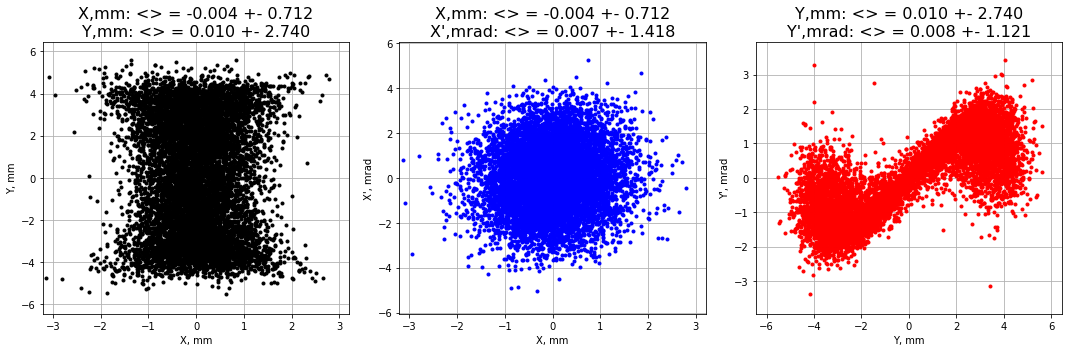

Modifying lattice:
Update n.11 : knll =  6.66045892032e-06  -->  6.99348186634e-06 ; cnll =  0.00660194941904  -->  0.00627185194809
Update n.12 : knll =  6.4184206196e-06  -->  6.73934165058e-06 ; cnll =  0.00672527708956  -->  0.00638901323508
Update n.13 : knll =  5.98354179042e-06  -->  6.28271887994e-06 ; cnll =  0.00696538466453  -->  0.0066171154313
Update n.14 : knll =  5.43152402347e-06  -->  5.70310022464e-06 ; cnll =  0.0073107749875  -->  0.00694523623812
Update n.15 : knll =  4.83658520537e-06  -->  5.07841446564e-06 ; cnll =  0.00774737982181  -->  0.00736001083072
Update n.16 : knll =  4.25411957085e-06  -->  4.46682554939e-06 ; cnll =  0.0082607489404  -->  0.00784771149338
Update n.17 : knll =  3.71696293946e-06  -->  3.90281108643e-06 ; cnll =  0.0088375148011  -->  0.00839563906105
Update n.18 : knll =  3.23971424989e-06  -->  3.40169996238e-06 ; cnll =  0.00946609625882  -->  0.00899279144588
Update n.19 : knll =  2.82515156234e-06  -->  2.96640914046e-06 ; cnll =  

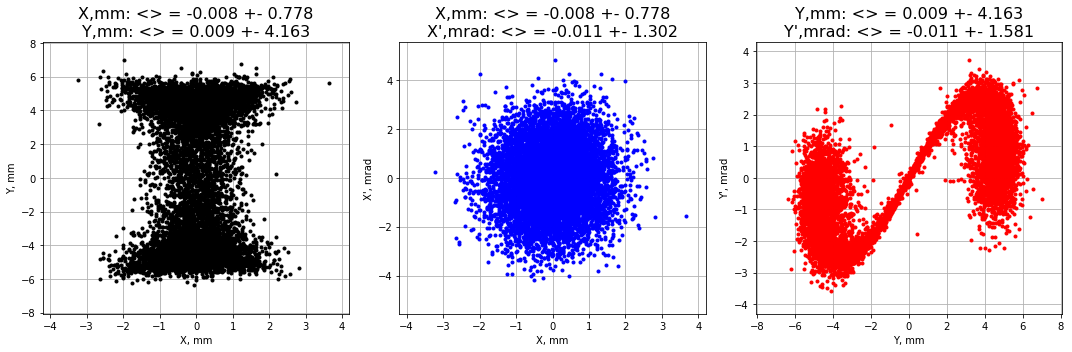

In [3]:
# 
# This script uses parts of scripts 'turn_aend_action_lattice_edit.py' (Chris) 
# and 'variabledNLsimulation_v0.py' (Yury)
#
#    Started at June 13, 2019
#
import synergia
import sys
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import rssynergia 
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import plotbeam
from rssynergia.base_diagnostics import pltbunch

def plotcoordDistr(bunchParticles):
#    
# Plot X-X', Y-Y', and X-Y distributions for 'bunchParticles'
#
    shapePartcls = bunchParticles.shape
    numbPartcls = shapePartcls[0]
    shapePartcls[0]
    particles = bunchParticles.real
    newCoordinates = np.zeros((6,numbPartcls))
    for k in range(numbPartcls):
        for j in range(6):
            newCoordinates[j,k] = 1.e3*particles[k,j]       # Units: mm and mrad 
    xmax = 1.15*np.max(newCoordinates[0,:])
    xpmax = 1.15*np.max(newCoordinates[1,:])
    ymax = 1.15*np.max(newCoordinates[2,:])
    ypmax = 1.15*np.max(newCoordinates[3,:])
    meanX = np.mean(newCoordinates[0,:])
    meanPX = np.mean(newCoordinates[1,:])
    stdX = np.std(newCoordinates[0,:])
    stdPX = np.std(newCoordinates[1,:])
    meanY = np.mean(newCoordinates[2,:])
    meanPY = np.mean(newCoordinates[3,:])
    stdY = np.std(newCoordinates[2,:])
    stdPY = np.std(newCoordinates[3,:])

    #another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(newCoordinates[0,:],newCoordinates[2,:],'.',color='k')
    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
    ax0.set_title(x0Title,fontsize='16')
    ax0.set_xlim([-xmax,xmax])
    ax0.set_ylim([-ymax,ymax])
    ax0.set_xlabel('X, mm')
    ax0.set_ylabel('Y, mm')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(newCoordinates[0,:],newCoordinates[1,:],'.',color='b')
    x1Title = "X,mm: <> = {:.3f} +- {:.3f}\nX\',mrad: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanPX,stdPX)
    ax1.set_title(x1Title,fontsize='16')
    ax1.set_xlim([-xmax,xmax])
    ax1.set_ylim([-xpmax,xpmax])
    ax1.set_xlabel('X, mm')
    ax1.set_ylabel('X\', mrad')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(newCoordinates[2,:],newCoordinates[3,:],'.',color='r')
    x2Title = "Y,mm: <> = {:.3f} +- {:.3f}\nY\',mrad: <> = {:.3f} +- {:.3f}".format(meanY,stdY,meanPY,stdPY)
    ax2.set_title(x2Title,fontsize='16')
    ax2.set_xlim([-ymax,ymax])
    ax2.set_ylim([-ypmax,ypmax])
    ax2.set_xlabel('Y, mm')
    ax2.set_ylabel('Y\', mrad')
    ax2.grid(True)
    
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

# Pickle helper is not necessary but is retained for this example
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state
        
# Derived class to ramp quadrupoles

# Will be passed into propagator and called at each appropriate 'interval' (step, turn, action, etc...)

class Ramp_actions(synergia.simulation.Propagate_actions, Pickle_helper):
# The arguments to __init__ are what the Ramp_actions instance is initialized with
    def __init__(self, multiplier1,multiplier2):
        selfObject = synergia.simulation.Propagate_actions.__init__(self)
# To recognize attributes of 'selfObject':
#        printAttributes(selfObject,'selfObject','synergia.simulation.Propagate_actions.__init__(self)')

# Pickling the arguments to the initializer allows the module to resume
# after checkpointing. They should be in the same order as the arguments to __init__.
        Pickle_helper.__init__(self, multiplier1,multiplier2)
        self.multiplier1 = multiplier1
        self.multiplier2 = multiplier2
    def turn_end_action(self, stepper, bunch, turn_num):
# For checking:        
        print "Modifying lattice:"
        for element in stepper.get_lattice_simulator().get_lattice().get_elements():
            if element.get_type() == "nllens":
                old_knll = element.get_double_attribute("knll")
                element.set_double_attribute("knll", self.multiplier1*old_knll)
                old_cnll = element.get_double_attribute("cnll")
                element.set_double_attribute("cnll", self.multiplier2*old_cnll)
# For checking:        
                print "Update", element.get_name(),": knll = ",old_knll," --> ",self.multiplier1*old_knll, \
                "; cnll = ",old_cnll," --> ",self.multiplier2*old_cnll
        stepper.get_lattice_simulator().update()
    
# Routine Simulation Setup

# Lattice:
print "\nIOTA Nonlinear lattice '.../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx'\n"
lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
"../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")
# To recognize attributes of 'lattice':
# printAttributes(lattice,'lattice','synergia.lattice.MadX_reader().get_lattice')

'''
# For checking only:
k = 0
for elem in lattice.get_elements():
    if k == 0:
        printAttributes(elem,'elem','lattice.get_elements')
    k += 1
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
    else:
        elem.set_string_attribute("extractor_type", "chef_map")
    print "elem ({}): name = {}, type = {}, stringAttrbt ={}". \
          format(k,elem.get_name(),elem.get_type(),elem.get_string_attribute("extractor_type"))
'''    

# Original version:
# attice_simulator = synergia.simulation.Lattice_simulator(lattice, 2)
# Bunch:
# bunch = synergia.optics.generate_matched_bunch_transverse(lattice_simulator, 1e-6, \
#                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)

# YuE version:
stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# Bunch:
bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)
#-------------------------------------------------
# For checking only:
#
# 1) Attributes:
# printAttributes(bunch,'bunch','synergia.optics.generate_matched_bunch_transverse')
# 2) Distributions X-Y, X-X', Y-Y' using method 'pltbunch.plot_bunch':
loclTitle = "\nThese distributions were constructed using \
'synergia.optics.generated_matched_bunch_transverse' method:\n"
print loclTitle
pltbunch.plot_bunch(bunch_origin)     
# 3) Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
# printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
plotcoordDistr(bunchParticles)
#--------------------------------------------------


# Steppers (YuE: both case 'splitoperator' and 'independent' work properly!):
# stepper = 'splitoperator'
stepper = 'independent'
if stepper == "splitoperator":
    # Use the Split operator stepper with a dummy collective operator
    # (with evenly-spaced steps)
    no_op = synergia.simulation.Dummy_collective_operator("stub")
    stepper = synergia.simulation.Split_operator_stepper(
                            lattice_simulator_Crrnt, no_op, 4)
elif stepper == "independent":
    # Use the Independent particle stepper (by element)
    stepper = synergia.simulation.Independent_stepper_elements(
                            lattice_simulator_Crrnt, 4)
else:
    sys.stderr.write("fodo.py: stepper must be either 'independent' or 'splitoperator'\n")
    sys.exit(1)


# Bunch simulator:
bunch_simulator = synergia.simulation.Bunch_simulator(bunch_origin)

'''
# Diagnostics:
diagnostic_flag = 'None'
for part in range(0, 0):
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("step_track_%02d.h5" % part,
                                                                   part))
if diagnostic_flag == 'step_full2':
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_full2("step_full2.h5"))
if diagnostic_flag == 'step_particles':
    bunch_simulator.add_per_step(synergia.bunch.Diagnostics_particles("step_particles.h5"))
for part in range(0, 0):
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_track("turn_track_%02d.h5" % part,
                                                                   part))
if diagnostic_flag == 'turn_full2':
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_full2("turn_full2.h5"))
if diagnostic_flag == 'turn_particles':
    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_particles("turn_particles.h5"))
'''    

#---------------------------
# Propagate
#---------------------------
# Ramp action is instantiated and passed to the propagator instance during the propagate method

print "\n-------------------\n"
print "           Nonlinear parameters are not changed"
print "\n-------------------\n"

bunch = bunch_origin
bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

ramp_actions = Ramp_actions(1.,1.)
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(0)
propagator.set_checkpoint_with_xml(True)
for turnCrrnt in range(5):
    propagatorCrrnt = propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)
    turnNumber = turnCrrnt+1
    print "              After turn ",turnNumber
# To recognize attributes of 'propagatorCrrnt':
#    printAttributes(propagatorCrrnt,'propagatorCrrnt', \
#                    'propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)')
    bunchParticles = bunch.get_local_particles()
    plotcoordDistr(bunchParticles)


print "\n-------------------\n"
print "           Nonlinear parameters will be CHANGED with values = 5% after each turn"
print "\n-------------------\n"
bunch = bunch_origin
bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

ramp_actions = Ramp_actions(1.05,.95)
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(0)
propagator.set_checkpoint_with_xml(True)
for turnCrrnt in range(5):
    propagatorCrrnt = propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)
    turnNumber = turnCrrnt+1
    print "              After turn ",turnNumber
# To recognize attributes of 'propagatorCrrnt':
#    printAttributes(propagatorCrrnt,'propagatorCrrnt', \
#                    'propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)')
    bunchParticles = bunch.get_local_particles()
    plotcoordDistr(bunchParticles)
